### Import thư viện, khai báo đồ

In [7]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from underthesea import word_tokenize

import numpy as np
import pickle, os
import regex as re
import unicodedata, time


MODEL_PATH = "D:/KLTN/QLCN/data/0905"
MODEL_PATH_VNCORE = "D:/KLTN/QLCN/data/0905/vncorenlp"

In [2]:
# # py_vncorenlp.download_model()
# rdrsegmenter = py_vncorenlp.VnCoreNLP()

In [3]:
# from jnius import autoclass

# # Thiết lập các tùy chọn JVM
# autoclass('java.lang.System').setProperty('java.util.logging.config.file', 'logging.properties')
# autoclass('java.lang.System').setProperty('java.awt.headless', 'true')
# autoclass('java.lang.System').setProperty('file.encoding', 'UTF-8')

# # Thiết lập kích thước Heap Space
# autoclass('java.lang.System').setProperty('Xms', '512m')  # Dung lượng tối thiểu
# autoclass('java.lang.System').setProperty('Xmx', '4g')  # Dung lượng tối đa

# # Khởi tạo bất kỳ lớp nào để áp dụng các tùy chọn
# autoclass('java.lang.Object')


In [2]:
with open("D:/KLTN/QLCN/data/vietnamese-stopwords-dash.txt", "r", encoding='utf-8') as file:
    stopword_vi_list = file.read().splitlines()
with open("D:/KLTN/QLCN/data/english-stopwords.txt", "r", encoding='utf-8') as file:
    stopword_eng_list = file.read().splitlines()

def remove_stopwords(line):
    words = []
    for word in line.strip().split():
        if word not in stopword_vi_list and word not in stopword_eng_list:
            words.append(word)
    return ' '.join(words)

### Tiền xử lý

In [3]:
bang_nguyen_am = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]
bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']

nguyen_am_to_ids = {}

for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)

def chuan_hoa_dau_tu_tieng_viet(word):
    if not is_valid_vietnam_word(word):
        return word

    chars = list(word)
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        if y != 0:
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0]
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word

    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            return ''.join(chars)

    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
        else:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    return ''.join(chars)

def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x != -1:
            if nguyen_am_index == -1:
                nguyen_am_index = index
            else:
                if index - nguyen_am_index != 1:
                    return False
                nguyen_am_index = index
    return True


def chuan_hoa_dau_cau_tieng_viet(sentence):
    words = sentence.split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        # print(cw)
        if len(cw) == 3:
            cw[1] = chuan_hoa_dau_tu_tieng_viet(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

def text_preprocess(document):
    # phải đưa về chữ thường trước cái tokenization
    document = document.lower() 
    # bỏ link
    document = re.sub(r'https?://\S+', '', document) 
    # bỏ số trong ngoặc vuông
    document = re.sub(r'\[\d+(?:,\s?\d+)*\]', '', document) 
    # chuẩn hóa unicode
    document = unicodedata.normalize('NFC', document)

    document = chuan_hoa_dau_cau_tieng_viet(document)
    # phân đoạn từ
    document = word_tokenize(document, format="text") # ờ t muốn check coi thí dù hòa đồng và hoà đồng có giống nhau không
    # bỏ stopword
    document = remove_stopwords(document) 
    # xóa các ký tự không cần thiết
    document = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',document)
    # xóa khoảng trắng thừa
    document = re.sub(r'\s+', ' ', document).strip()
    return document

In [3]:
train_text = pickle.load(open(os.path.join(MODEL_PATH,"train_text.pkl"), 'rb'))
train_label = pickle.load(open(os.path.join(MODEL_PATH,"train_label.pkl"), 'rb'))
test_text = pickle.load(open(os.path.join(MODEL_PATH,"test_text.pkl"), 'rb'))
test_label = pickle.load(open(os.path.join(MODEL_PATH,"test_label.pkl"), 'rb'))

In [7]:
# chunk_size = 1000  # Kích thước của mỗi phần
# start_time = time.time()

# # Tạo một danh sách mới để lưu trữ kết quả sau khi xử lý
# processed_text = []

# # Xử lý từng phần của train_text_t
# for i in range(0, len(train_text_t), chunk_size):
#     chunk = train_text_t[i:i+chunk_size]
#     processed_chunk = [text_preprocess(s) for s in chunk]
#     processed_text.extend(processed_chunk)
#     # Giải phóng bộ nhớ của phần đã xử lý
#     del processed_chunk
#     print('Done train_text_preprocess', i)

# # Giải phóng bộ nhớ của danh sách kết quả cuối cùng
# del train_text_t

# end_time = time.time() - start_time
# print('Done train_text_preprocess in', end_time, 'seconds.')


In [8]:
# chunk_size = 1000  # Kích thước của mỗi phần
# start_time = time.time()

# # Xử lý từng phần của train_text
# test_text = []
# for i in range(0, len(test_text_t), chunk_size):
#     chunk = test_text_t[i:i+chunk_size]
#     processed_chunk = [text_preprocess(s) for s in chunk]
#     test_text.extend(processed_chunk)
#     print('Done test_text_preprocess', i)

# end_time = time.time() - start_time
# print('Done test_text_preprocess in', end_time, 'seconds.')

In [9]:

# pickle.dump(train_text, open(os.path.join(MODEL_PATH_VNCORE,"train_text_preprocess.pkl"), 'wb'))
# pickle.dump(test_text, open(os.path.join(MODEL_PATH_VNCORE,"test_text_preprocess.pkl"), 'wb'))

In [8]:
train_text = pickle.load(open(os.path.join(MODEL_PATH_VNCORE,"train_text_preprocess.pkl"), 'rb'))
train_label = pickle.load(open(os.path.join(MODEL_PATH,"train_label.pkl"), 'rb'))
test_text = pickle.load(open(os.path.join(MODEL_PATH_VNCORE,"test_text_preprocess.pkl"), 'rb'))
test_label = pickle.load(open(os.path.join(MODEL_PATH,"test_label.pkl"), 'rb'))

In [10]:
start_time = time.time()
train_text = [text_preprocess(s) for s in train_text]
end_time = time.time() - start_time
print('Done train_text_preprocess in', end_time, 'seconds.')

start_time = time.time()
test_text = [text_preprocess(s) for s in test_text]
end_time = time.time() - start_time
print('Done test_text_preprocess in', end_time, 'seconds.')

pickle.dump(train_text, open(os.path.join(MODEL_PATH_VNCORE,"train_text_preprocess.pkl"), 'wb'))
pickle.dump(test_text, open(os.path.join(MODEL_PATH_VNCORE,"test_text_preprocess.pkl"), 'wb'))

Done train_text_preprocess in 7475.834928274155 seconds.
Done test_text_preprocess in 2656.1715931892395 seconds.


In [11]:
train_text

['chủ_tịch vinasa_trương gia_bình tin_tưởng diễn_đàn đem lợi_ích thiết_thực phát_triển kinh_tế ảnh t hvietnam họp_báo thềm sự_kiện diễn hà_nội 2310 đại_diện ban tổ_chức thủ_tướng chính_phủ việt_nam nguyễn tấn_dũng cựu thủ_tướng nhật_bản yukio_hatoyama mời danh_dự diễn_đàn sự_kiện thu_hút 700 đại_biểu 200 đại_biểu quốc_tế lãnh_đạo hiệp_hội tập_đoàn công_nghệ hàng_đầu 20 kinh_tế tham_gia trọng_tâm diễn_đàn chuyên_đề chuyên_đề công_nghệ_thông_tin tái cấu_trúc nông_nghiệp diễn_giả câu_chuyện thực_tiễn kinh_nghiệm quốc_gia nông_nghiệp tiên_tiến nhật_bản israel chuyên_đề phương_thức phát_triển nâng hiệu_quả dịch_vụ công bàn đổi_mới thể_chế ứng_dụng công_nghệ thực_trạng hiệu_quả ứng_dụng công_nghệ giao_thông thông_minh y_tế thông_minh chuyên_đề c nền_tảng công_nghệ phát_triển thông_minh nền_tảng phát_triển mô_hình kinh_doanh thách_thức doanh_nghiệp khuôn_khổ diễn_đàn sự_kiện công_nghệ_thông_tin nhật_bản 2014 diễn 3010 tiêu_điểm sự_kiện chủ_đề phát_triển nhân_lực công_nghệ hợp_tác việt_nam nhậ

In [9]:
lb_encoder = LabelEncoder()
lb_encoder.fit(train_label)

train_label = lb_encoder.transform(train_label)
test_label = lb_encoder.transform(test_label)

pickle.dump(lb_encoder, open(os.path.join(MODEL_PATH, "label_encoder.pkl"), 'wb'))


### Training

In [10]:
MODEL_PATH_1405 = "D:/KLTN/QLCN/data/1405"


start_time = time.time()
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,1),
                                             max_df=0.8,
                                             max_features=None)), 
                     ('tfidf', TfidfTransformer()), 
                     ('clf', MultinomialNB())
                    ])
text_clf = text_clf.fit(train_text, train_label)

train_time = time.time() - start_time
print('Done training Naive Bayes in', train_time, 'seconds.')

# Save model
pickle.dump(text_clf, open(os.path.join(MODEL_PATH_1405, "naive_bayes.pkl"), 'wb'))

        
start_time = time.time()
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,1),
                                             max_df=0.8,
                                             max_features=None)), 
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression(solver='lbfgs', 
                                                multi_class='auto',
                                                max_iter=10000))
                    ])
text_clf = text_clf.fit(train_text, train_label)

train_time = time.time() - start_time
print('Done training Linear Classifier in', train_time, 'seconds.')

# Save model
pickle.dump(text_clf, open(os.path.join(MODEL_PATH_1405, "linear_classifier.pkl"), 'wb'))


pickle.dump(train_text, open(os.path.join(MODEL_PATH_1405,"train_text_preprocess.pkl"), 'wb'))
pickle.dump(test_text, open(os.path.join(MODEL_PATH_1405,"test_text_preprocess.pkl"), 'wb'))
pickle.dump(train_label, open(os.path.join(MODEL_PATH_1405,"train_label_preprocess.pkl"), 'wb'))
pickle.dump(test_label, open(os.path.join(MODEL_PATH_1405,"test_label_preprocess.pkl"), 'wb'))

Done training Naive Bayes in 22.842522382736206 seconds.
Done training Linear Classifier in 213.36629676818848 seconds.


In [13]:
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import os

# Define model path
MODEL_PATH_1405_2 = "D:/KLTN/QLCN/data/1405_2"

# Parameters for GridSearchCV
nb_parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.75, 0.8, 0.85],
    'clf__alpha': [0.1, 0.5, 1.0]
}

lr_parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.75, 0.8, 0.85],
    'clf__C': [0.1, 1, 10]
}

# Training and saving Naive Bayes model with GridSearchCV
start_time = time.time()

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

nb_grid_search = GridSearchCV(nb_pipeline, nb_parameters, cv=5, n_jobs=2)
nb_grid_search.fit(train_text, train_label)

train_time = time.time() - start_time
print('Done training Naive Bayes with GridSearchCV in', train_time, 'seconds.')
print('Best parameters for Naive Bayes found:', nb_grid_search.best_params_)

# Save best Naive Bayes model
pickle.dump(nb_grid_search.best_estimator_, open(os.path.join(MODEL_PATH_1405_2, "optimized_naive_bayes.pkl"), 'wb'))

# Training and saving Logistic Regression model with GridSearchCV
start_time = time.time()

lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000))
])

lr_grid_search = GridSearchCV(lr_pipeline, lr_parameters, cv=5, n_jobs=2)
lr_grid_search.fit(train_text, train_label)

train_time = time.time() - start_time
print('Done training Logistic Regression with GridSearchCV in', train_time, 'seconds.')
print('Best parameters for Logistic Regression found:', lr_grid_search.best_params_)

# Save best Logistic Regression model
pickle.dump(lr_grid_search.best_estimator_, open(os.path.join(MODEL_PATH_1405_2, "optimized_linear_classifier.pkl"), 'wb'))



In [ ]:
# from sklearn.svm import SVC

# start_time = time.time()
# text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,1),
#                                              max_df=0.8,
#                                              max_features=None)), 
#                      ('tfidf', TfidfTransformer()),
#                      ('clf', SVC(gamma='scale'))
#                     ])
# text_clf = text_clf.fit(train_text, train_labels)

# train_time = time.time() - start_time
# print('Done training SVM in', train_time, 'seconds.')

# # Save model
# pickle.dump(text_clf, open(os.path.join(MODEL_PATH, "svm.pkl"), 'wb'))

### Grade

In [14]:
# Naive Bayes
model = pickle.load(open(os.path.join(MODEL_PATH_VNCORE,"naive_bayes.pkl"), 'rb'))
y_pred = model.predict(test_text)
print('Naive Bayes, Accuracy =', np.mean(y_pred == test_label))

# Linear Classifier
model = pickle.load(open(os.path.join(MODEL_PATH_VNCORE,"linear_classifier.pkl"), 'rb'))
y_pred = model.predict(test_text)
print('Linear Classifier, Accuracy =', np.mean(y_pred == test_label))


Naive Bayes, Accuracy = 0.8207179487179487
Linear Classifier, Accuracy = 0.8515769230769231


In [15]:
nb_model = pickle.load(open(os.path.join(MODEL_PATH_VNCORE,"naive_bayes.pkl"), 'rb'))
y_pred = nb_model.predict(test_text)
print(classification_report(test_label, y_pred, target_names=list(lb_encoder.classes_)))

lc_model = pickle.load(open(os.path.join(MODEL_PATH_VNCORE,"linear_classifier.pkl"), 'rb'))
y_pred = lc_model.predict(test_text)
print(classification_report(test_label, y_pred, target_names=list(lb_encoder.classes_)))



              precision    recall  f1-score   support

   Công nghệ       0.91      0.75      0.82      6000
    Giáo dục       0.87      0.89      0.88      6000
    Giải trí       0.80      0.88      0.84      6000
    Khoa học       0.85      0.79      0.82      6000
     Kinh tế       0.77      0.79      0.78      6000
     Nhà đất       0.75      0.82      0.78      6000
   Pháp luật       0.80      0.79      0.80      6000
    Thế giới       0.85      0.91      0.88      6000
    Thể thao       0.96      0.95      0.96      6000
     Văn hóa       0.71      0.70      0.70      6000
       Xe cộ       0.95      0.87      0.91      6000
      Xã hội       0.73      0.66      0.69      6000
    Đời sống       0.78      0.87      0.82      6000

    accuracy                           0.82     78000
   macro avg       0.82      0.82      0.82     78000
weighted avg       0.82      0.82      0.82     78000

              precision    recall  f1-score   support

   Công nghệ       0.88 

## Lấy dữ liệu

In [4]:
MODEL_PATH1 = "D:/KLTN/QLCN/data/models"

In [5]:
label_encoder = pickle.load(open(os.path.join(MODEL_PATH1,"label_encoder.pkl"), 'rb'))

model2_0905 = pickle.load(open(os.path.join(MODEL_PATH_VNCORE,"naive_bayes.pkl"), 'rb'))
model3_0905 = pickle.load(open(os.path.join(MODEL_PATH_VNCORE,"linear_classifier.pkl"), 'rb'))

model2 = pickle.load(open(os.path.join(MODEL_PATH1,"naive_bayes.pkl"), 'rb'))
model3 = pickle.load(open(os.path.join(MODEL_PATH1,"linear_classifier.pkl"), 'rb'))
model4 = pickle.load(open(os.path.join(MODEL_PATH1,"svm.pkl"), 'rb'))

In [6]:
def predict_tag (text, modelx):
    text = text_preprocess(text)

    probabilities = modelx.predict_proba([text])[0]
    top_labels_indices = probabilities.argsort()[-2:][::-1]
    top_labels = modelx.classes_[top_labels_indices]

    top_probabilities = probabilities[top_labels_indices]

    # In ra nhãn và xác suất
    for label, prob in zip(top_labels, top_probabilities):
        print(f"Nhãn: {label}, Xác suất: {prob:.4f}")

    if abs(top_probabilities[0] - top_probabilities[1]) <= 0.3:
        lb = [label_encoder.inverse_transform([x]) for x in top_labels]
        print(lb)
    elif top_probabilities[0] > top_probabilities[1]:
        print (label_encoder.inverse_transform([top_labels[0]]))
    else:
        print(label_encoder.inverse_transform([top_labels[1]]))

In [47]:
# from docx import Document
# file_path = "C:/Users/Hi/Desktop/pj dtmn.docx"
# document = Document(file_path)
# all_text = ""
# for paragraph in document.paragraphs:
#     all_text += paragraph.text + "\n"

import PyPDF2
# file_path = "C:/Users/Hi/Desktop/9F9B291C-5A9E-11EE-90B6-F71C97318934.pdf" #cái này bất ổn quá
file_path = "D:/KLTN/TEMP/text/doisong.pdf"
# file_path = "D:/AI+/Các hệ thống thông minh.pdf"

with open(file_path, 'rb') as file:
    reader = PyPDF2.PdfReader(file)
    
    all_text = ""
    for page_number in range(len(reader.pages)):
        page = reader.pages[page_number]
        all_text += page.extract_text()


In [48]:
text = text_preprocess(all_text)
text

'1 cơ_sở sản_xuất hồ chí_minh loại_hình lao_động đổi_mới 1986 hồ chí_minh liên_tục tăng_trưởng kinh_tế tỉnh_thành việt_nam hồ chí_minh ra_đời phát_triển cssxn quan_hệ đan_xen hỗ_tương loại_hình tổ_chức sản_xuất công_ty trách_nhiệm hữu_hạn công_ty tư_nhân doanh_nghiệp v v khắp thành_phố ven khu công_nghiệp khu chế_xuất hoạt_động kinh_tế cssxn tồn_tại phổ_biến khu dân_cư đa_dạng ngành_nghề hoạt_động kinh_tế thành_phố tiếp_nhận nguyên_liệu hàng hóa tiêu_thụ gia_công chế_biến số_lượng hồ chí_minh cung_ứng hàng_tiêu_dùng gia_dụng hàng vật_tư dụng_cụ sản_xuất v v vùng_miền mặc_dù loại_hình doanh_nghiệp doanh_nghiệp tư_nhân công_ty trách_nhiệm hữu_hạn công_ty cổ_phần đời_sống xã_hội thanh_niên nhập_cư lao_động phổ_thông cơ_sở sản_xuất thành_phố hồ chí_minh_phạm 1 tóm_tắt viết trình_bày kết_quả nghiên_cứu khía_cạnh đời_sống xã_hội thanh_niên nhập_cư lao_động phổ_thông cơ_sở sản_xuất hồ chí_minh khía_cạnh đời_sống xã_hội mạng_lưới xã_hội quan_hệ xã_hội sống làm_việc thu_nhập tiếp_cận dịch_vụ xã

In [51]:
predict_tag(text, model2_0905)
predict_tag(text, model3_0905)

predict_tag(text, model2)
predict_tag(text, model3)
# predict_tag(all_text, model4)


Nhãn: 1, Xác suất: 0.4062
Nhãn: 4, Xác suất: 0.2780
[array(['Giáo dục'], dtype='<U9'), array(['Kinh tế'], dtype='<U9')]
Nhãn: 4, Xác suất: 0.8879
Nhãn: 11, Xác suất: 0.0396
['Kinh tế']
Nhãn: 1, Xác suất: 0.3356
Nhãn: 4, Xác suất: 0.3066
[array(['Giáo dục'], dtype='<U9'), array(['Kinh tế'], dtype='<U9')]
Nhãn: 4, Xác suất: 0.9236
Nhãn: 11, Xác suất: 0.0261
['Kinh tế']


In [46]:
import fitz, string
# file_path ="C:/Users/Hi/Downloads/Jason_brownlee_-_Deep_learning_with_pyth.pdf"
file_path = "D:/KLTN/TEMP/text/doisong.docx"
# file_path = "C:/Users/Hi/Desktop/9F9B291C-5A9E-11EE-90B6-F71C97318934.pdf" #cái này bất ổn quá

def extract_text_from_pdf(file_path):
    text = ''
    with fitz.open(file_path) as doc:
        for page in doc:
            text += page.get_text()
    text  = text.splitlines()
    return concatenate_sentences(text)


def concatenate_sentences(sentence_list):
    concatenated_sentence = ""

    for i, sentence in enumerate(sentence_list):
        if sentence == '' or sentence is None:
            continue
        if i == len(sentence_list) - 1:
            concatenated_sentence += sentence
        else:
            ## sentence_list[i + 1] == '' trước để kiểm tra nó có rỗng không
            if sentence[-1] in string.punctuation or sentence_list[i + 1] == '' or sentence_list[i + 1][0] in string.punctuation:
                concatenated_sentence += sentence
            else:
                concatenated_sentence += sentence + " "

    return concatenated_sentence

# def concatenate_sentences(sentence_list):
#     concatenated_sentence = ''
#     for i, sentence in enumerate(sentence_list):
#         if i < len(sentence_list) - 1:
#             if sentence[-1] in string.punctuation or sentence_list[i + 1][0] in string.punctuation:
#                 concatenated_sentence += sentence
#             else:
#                 concatenated_sentence += sentence + ' '
#         else:
#             concatenated_sentence += sentence
#     return concatenated_sentence

In [48]:
text = extract_text_from_pdf(file_path)
text = text_preprocess(text)
text

'_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ jason brownlee deep learning python develop deep learning models on_theano and_tensorflow keras deep learning python copyright 2016 jason brownlee rights reserved edition v1 7 contents preface iii introduction 1 1 2 1 1 deep learning wrong 2 1 2 deep learning python 3 1 3 book organization 3 1 4 requirements book 6 1 5 outcomes reading book 7 1 6 book 8 1 7_summary 9 background 10 2 introduction to theano 11 2 1 theano 11 2 2 to install theano 12 2 3 simple theano 12 2 4_extensions and_wrappers theano 13 2 5 theano resources 13 2 6_summary 14 3 introduction to tensorflow 15 3 1 tensorflow 15 3 2 to install tensorflow 15 3 3 examples in tensorflow 16 3 4 simple tensorflow 16 3 5 deep learning models 17 3 6_summary 17 4 introduction to keras 19 4 1 keras 19 4 2 to install keras 20 4 3_theano and_tensorflow backends keras 20 iii 4 4 build deep learning models keras 21 4 5_summary 22 5 project develop large models gpu

In [49]:
predict_tag(text, model2_0905)
predict_tag(text, model3_0905)

predict_tag(text, model2)
predict_tag(text, model3)
# predict_tag(all_text, model4)


Nhãn: 0, Xác suất: 0.9349
Nhãn: 2, Xác suất: 0.0250
['Công nghệ']
Nhãn: 0, Xác suất: 0.3176
Nhãn: 2, Xác suất: 0.1085
[array(['Công nghệ'], dtype='<U9'), array(['Giải trí'], dtype='<U9')]
Nhãn: 0, Xác suất: 0.8858
Nhãn: 10, Xác suất: 0.0413
['Công nghệ']
Nhãn: 9, Xác suất: 0.2241
Nhãn: 0, Xác suất: 0.2177
[array(['Văn hóa'], dtype='<U9'), array(['Công nghệ'], dtype='<U9')]


In [25]:

# Tiền xử lý văn bản mới
new_text_preprocessed = text_preprocess(text)  # Hàm preprocess_text là hàm tiền xử lý văn bản

# Sử dụng mô hình đã huấn luyện để dự đoán lớp của văn bản mới
predicted_class = model4.predict([new_text_preprocessed])[0]

# Sử dụng mô hình đã huấn luyện để dự đoán xác suất của từng lớp cho văn bản mới
decision_values = model4.decision_function([new_text_preprocessed])
# In kết quả dự đoán
print("Predicted class:", predicted_class)
print("Predicted probability:", decision_values)

Predicted class: 3
Predicted probability: [[10.29092308  1.72608935  0.72413956 12.30184865 11.29713618  5.75716998
   4.74897331  3.75484558 -0.29769568  8.17429424  2.72731053  7.09986603
   9.27373657]]


In [37]:
label_encoder = pickle.load(open(os.path.join(MODEL_PATH1,"label_encoder.pkl"), 'rb'))

model2_0905 = pickle.load(open(os.path.join(MODEL_PATH_VNCORE,"naive_bayes.pkl"), 'rb'))
model3_0905 = pickle.load(open(os.path.join(MODEL_PATH_VNCORE,"linear_classifier.pkl"), 'rb'))

model2 = pickle.load(open(os.path.join(MODEL_PATH1,"naive_bayes.pkl"), 'rb'))
model3 = pickle.load(open(os.path.join(MODEL_PATH1,"linear_classifier.pkl"), 'rb'))
model4 = pickle.load(open(os.path.join(MODEL_PATH1,"svm.pkl"), 'rb'))

In [7]:
import fitz, string

def extract_text_from_pdf(file_path):
    text = ''
    with fitz.open(file_path) as doc:
        for page in doc:
            text += page.get_text()
    text  = text.splitlines()
    return concatenate_sentences(text)


def concatenate_sentences(sentence_list):
    concatenated_sentence = ""

    for i, sentence in enumerate(sentence_list):
        if sentence == '' or sentence is None:
            continue
        if i == len(sentence_list) - 1:
            concatenated_sentence += sentence
        else:
            ## sentence_list[i + 1] == '' trước để kiểm tra nó có rỗng không
            if sentence[-1] in string.punctuation or sentence_list[i + 1] == '' or sentence_list[i + 1][0] in string.punctuation:
                concatenated_sentence += sentence
            else:
                concatenated_sentence += sentence + " "

    return concatenated_sentence

In [8]:
from docx import Document

def read_file(path):
    ext = os.path.splitext(path)[1]
    if ext == '.docx':
        doc = Document(path)
        content = ''
        for para in doc.paragraphs:
            content += para.text + '\n'
    else:
        content = extract_text_from_pdf(path)
    
    content = text_preprocess(content)        
    return content


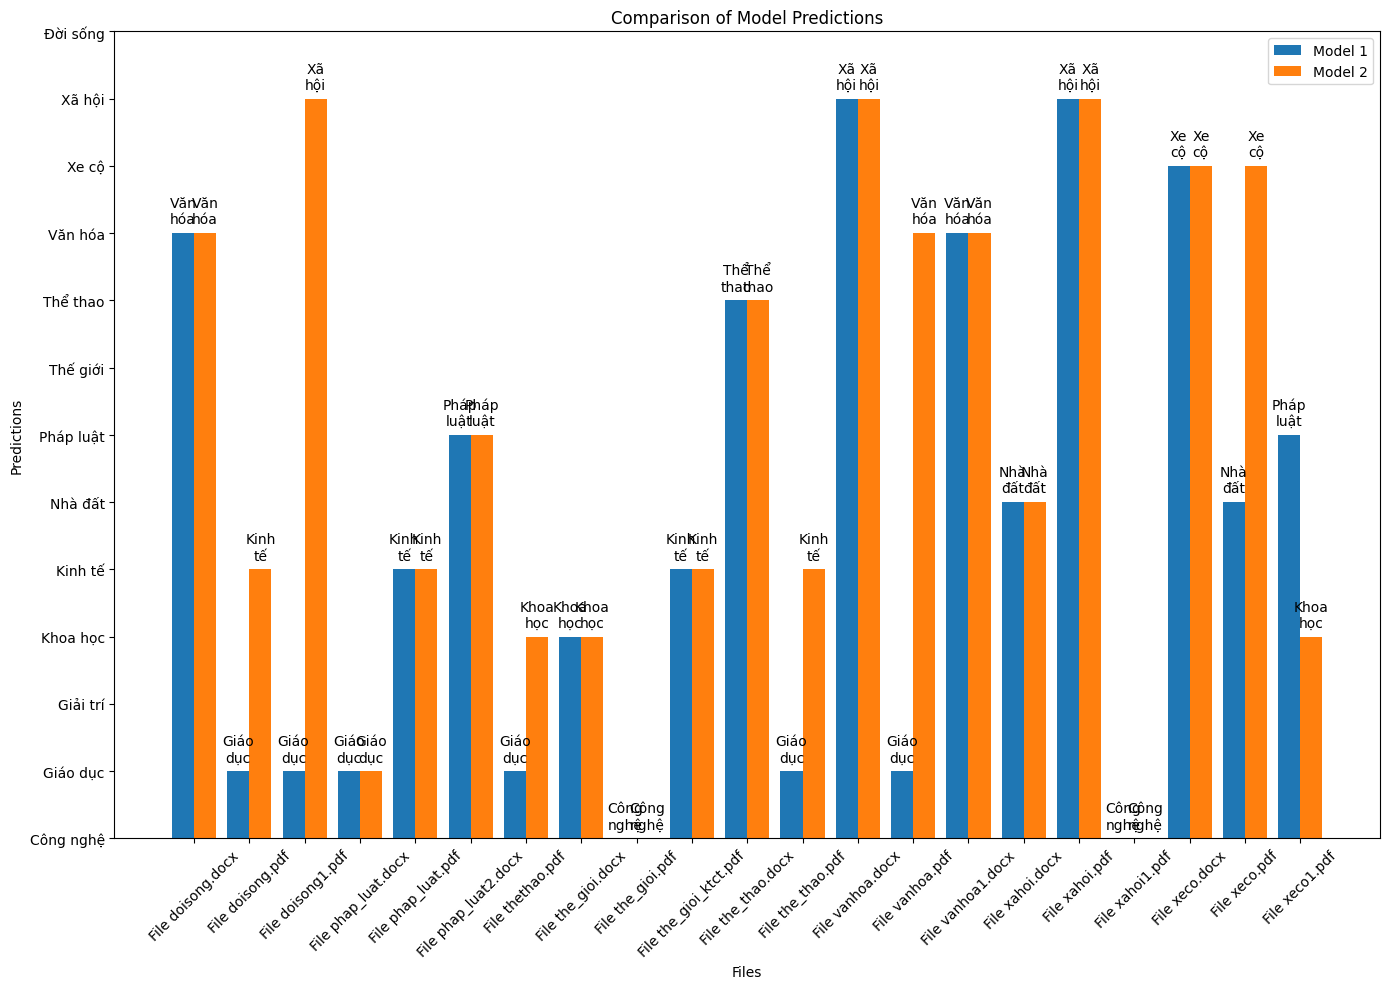

In [63]:
import os
import matplotlib.pyplot as plt

folder_path = "D:/KLTN/TEMP/text"
# Mảng để lưu các dự đoán
predict_tag1 = []
predict_tag2 = []
labels = []

# Thực hiện dự đoán
# label2_0905 = label_encoder.inverse_transform(model2_0905.predict([texts]))
# label3_0905 = label_encoder.inverse_transform(model3_0905.predict([texts]))

# label2 = label_encoder.inverse_transform(model2.predict([texts]))
# label3 = label_encoder.inverse_transform(model3.predict([texts]))

classes = label_encoder.classes_
# Thực hiện dự đoán
for i, file_name in enumerate(os.listdir(folder_path)):
    labels.append(f'File {file_name}')
    file_path = os.path.join(folder_path, file_name)
    
    # Sử dụng hàm read_file ở trên để đọc nội dung tệp
    text = read_file(file_path)    

    # Thực hiện dự đoán bằng model1 và model2
    # prediction_model1 = model2_0905.predict([text])[0]
    # prediction_model2 = model3_0905.predict([text])[0]
    prediction_model1 = model2.predict([text])[0]
    prediction_model2 = model3.predict([text])[0]
    # print(prediction_model1, prediction_model2)
    
    # Chuyển đổi số nguyên dự đoán thành nhãn thực tế
    label1 = label_encoder.inverse_transform([prediction_model1])[0]
    label2 = label_encoder.inverse_transform([prediction_model2])[0]
    # print(label1, label2)
    
    # Lưu dự đoán dưới dạng nhãn
    predict_tag1.append(prediction_model1)
    predict_tag2.append(prediction_model2)

x = np.arange(len(predict_tag1))
width = 0.4
# Vẽ biểu đồ
plt.figure(figsize=(14, 10))
bars1 = plt.bar(x - width/2, predict_tag1, width=width, align='center', label='Model 1')
bars2 = plt.bar(x + width/2, predict_tag2, width=width, align='center', label='Model 2')


for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        label = label_encoder.inverse_transform([yval])[0]
        label = label.replace(" ", "\n")
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.1, label, ha='center', va='bottom')

plt.xlabel('Files')
plt.ylabel('Predictions')
plt.xticks(x, labels, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.title('Comparison of Model Predictions')
plt.legend()
plt.tight_layout()  # Điều chỉnh layout để nhãn x không bị cắt
plt.show()


<Figure size 1400x1000 with 0 Axes>

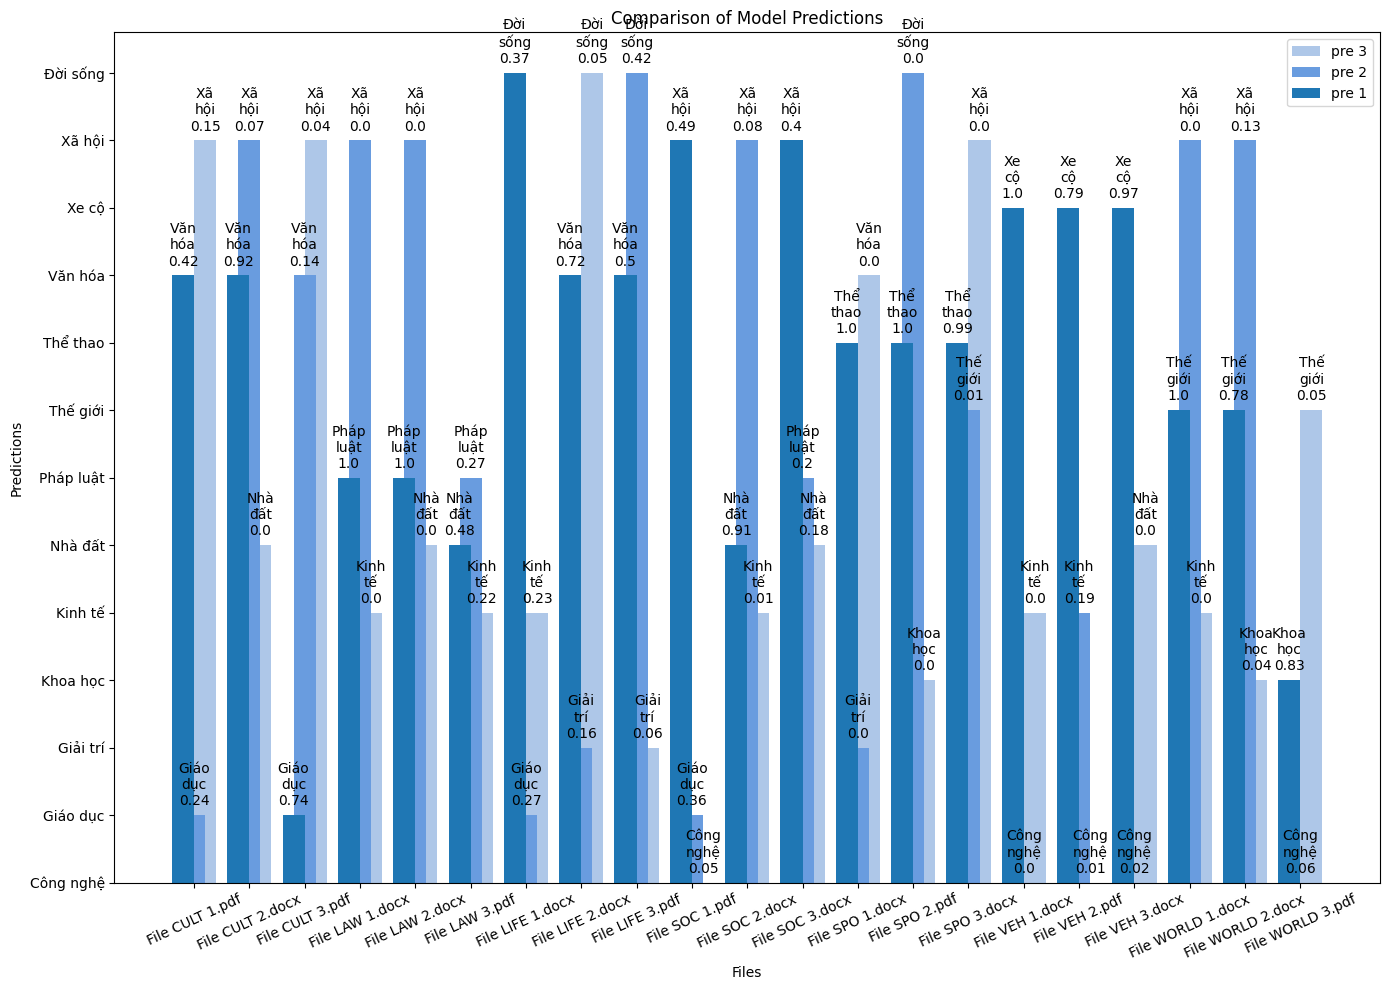

In [66]:
import os
import matplotlib.pyplot as plt

folder_path = "D:/KLTN/TEMP/text"

# Mảng để lưu các dự đoán
predict_tag1 = []
predict_tag2 = []
predict_tag3 = []
labels = []
label = []

classes = label_encoder.classes_
for i, file_name in enumerate(os.listdir(folder_path)):
    labels.append(f'File {file_name}')
    file_path = os.path.join(folder_path, file_name)
    
    text = read_file(file_path)    
    
    probabilities = model2_0905.predict_proba([text])[0]
    top_labels_indices = probabilities.argsort()[-3:][::-1] # ::-1 để đảo ngược mảng
    top_probabilities = probabilities[top_labels_indices]
    rounded_probabilities = [round(prob, 2) for prob in top_probabilities]

    label1 = label_encoder.inverse_transform([top_labels_indices[0]])[0].replace(" ", "\n") + "\n"+ str(rounded_probabilities[0])
    label2 = label_encoder.inverse_transform([top_labels_indices[1]])[0].replace(" ", "\n") + "\n"+ str(rounded_probabilities[1])
    label3 = label_encoder.inverse_transform([top_labels_indices[2]])[0].replace(" ", "\n") + "\n"+ str(rounded_probabilities[2])
    label.append([label1, label2, label3])
    # Lưu dự đoán dưới dạng nhãn
    predict_tag1.append(top_labels_indices[0])
    predict_tag2.append(top_labels_indices[1])
    predict_tag3.append(top_labels_indices[2])

x = np.arange(len(predict_tag1))
width = 0.4
# Vẽ biểu đồ
plt.figure(figsize=(14, 10))
colors = ['#1f77b4', '#699cdf', '#aec7e8'] 

# Vẽ biểu đồ
plt.figure(figsize=(14, 10))
bars3 = plt.bar(x + width/2, predict_tag3, width=width, align='center', label='pre 3', color=colors[2])
bars2 = plt.bar(x, predict_tag2, width=width, align='center', label='pre 2', color=colors[1])
bars1 = plt.bar(x - width/2, predict_tag1, width=width, align='center', label='pre 1', color=colors[0])


for i, bars in enumerate ([bars1, bars2, bars3]):
    for j, bar in enumerate (bars):
        yval = bar.get_height()
        # label = label_encoder.inverse_transform([yval])[0]
        # label = label.replace(" ", "\n")
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.1, label[j][i], ha='center', va='bottom')

plt.xlabel('Files')
plt.ylabel('Predictions')
plt.xticks(x, labels, rotation=25)
plt.yticks(np.arange(len(classes)), classes)
plt.title('Comparison of Model Predictions')
plt.legend()
plt.tight_layout()  # Điều chỉnh layout để nhãn x không bị cắt
plt.show()


In [130]:
# file_path = "C:/Users/Hi/AppData/Local/Temp/Zalo Temp/fdef304bb3151bb3673c14c8520993d8~/DATA/EDU 5.docx"

file_path ="D:/KLTN/TEMP/text/t.pdf"
text = read_file(file_path)    

probabilities = model3_0905.predict_proba([text])[0]
top_labels_indices = probabilities.argsort()[-3:][::-1] # ::-1 để đảo ngược mảng
top_probabilities = probabilities[top_labels_indices]
rounded_probabilities = [round(prob, 2) for prob in top_probabilities]

label1 = label_encoder.inverse_transform([top_labels_indices[0]])[0].replace(" ", "\n") + "\n"+ str(rounded_probabilities[0])
label2 = label_encoder.inverse_transform([top_labels_indices[1]])[0].replace(" ", "\n") + "\n"+ str(rounded_probabilities[1])
label3 = label_encoder.inverse_transform([top_labels_indices[2]])[0].replace(" ", "\n") + "\n"+ str(rounded_probabilities[2])

print(label1, label2, label3)

Giáo
dục
0.61 Công
nghệ
0.35 Khoa
học
0.01


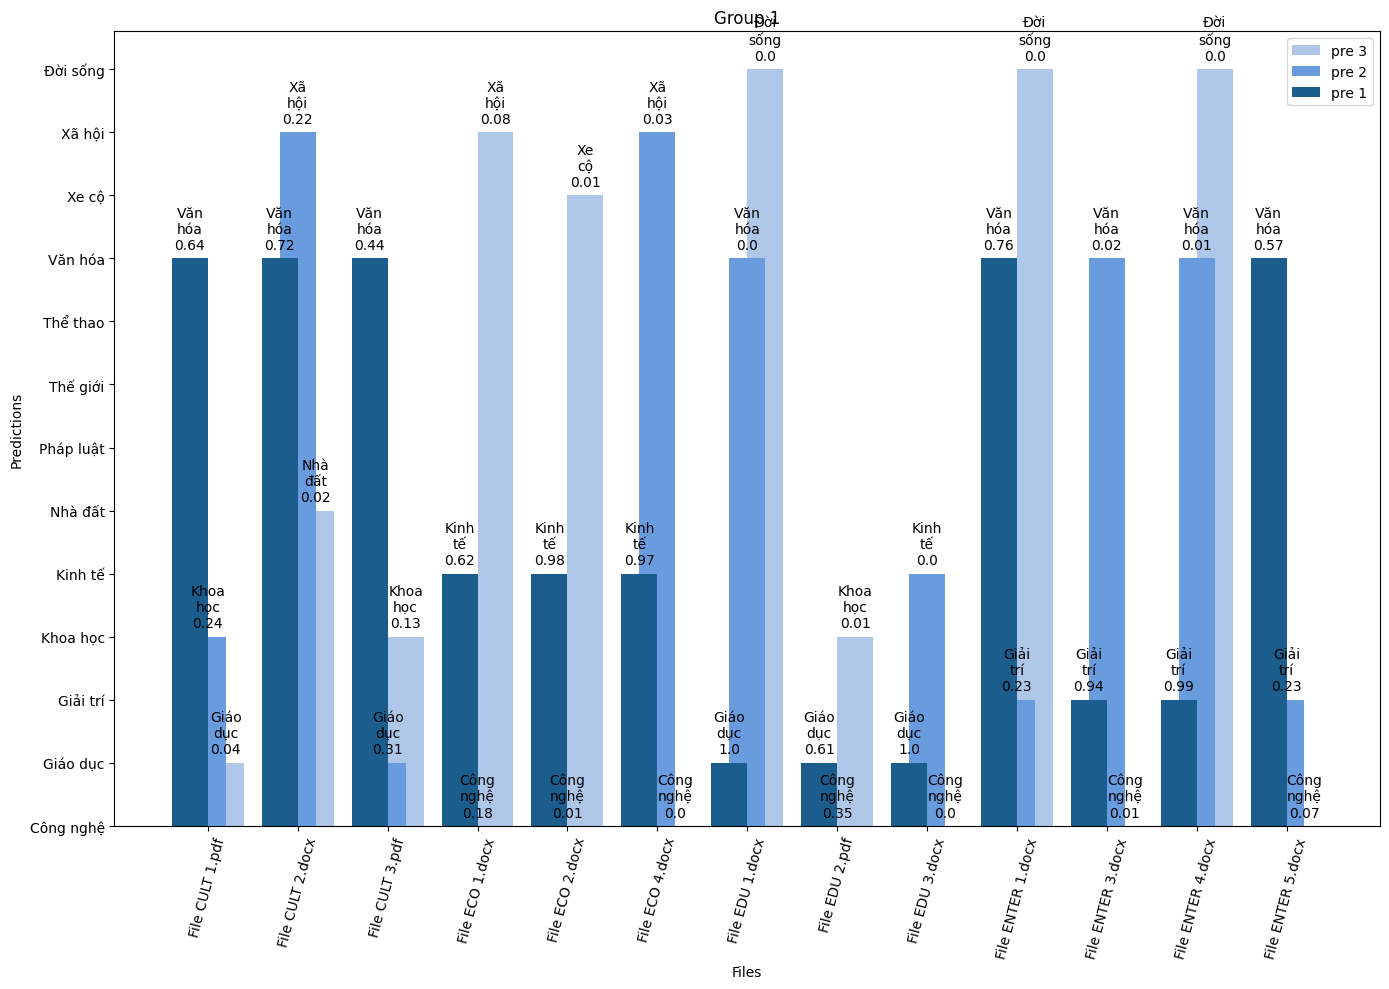

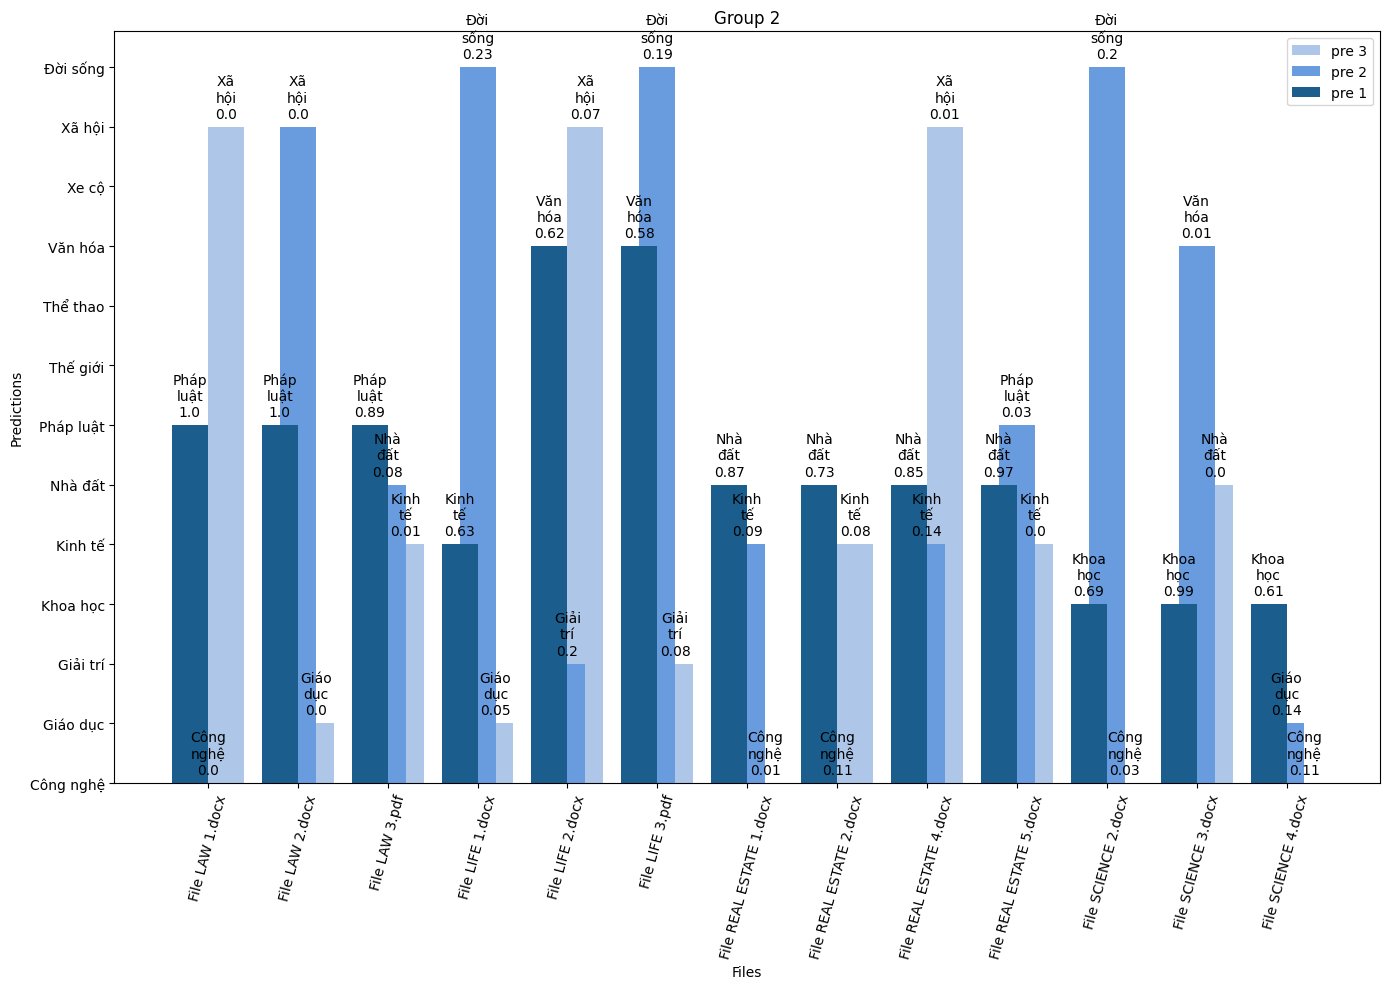

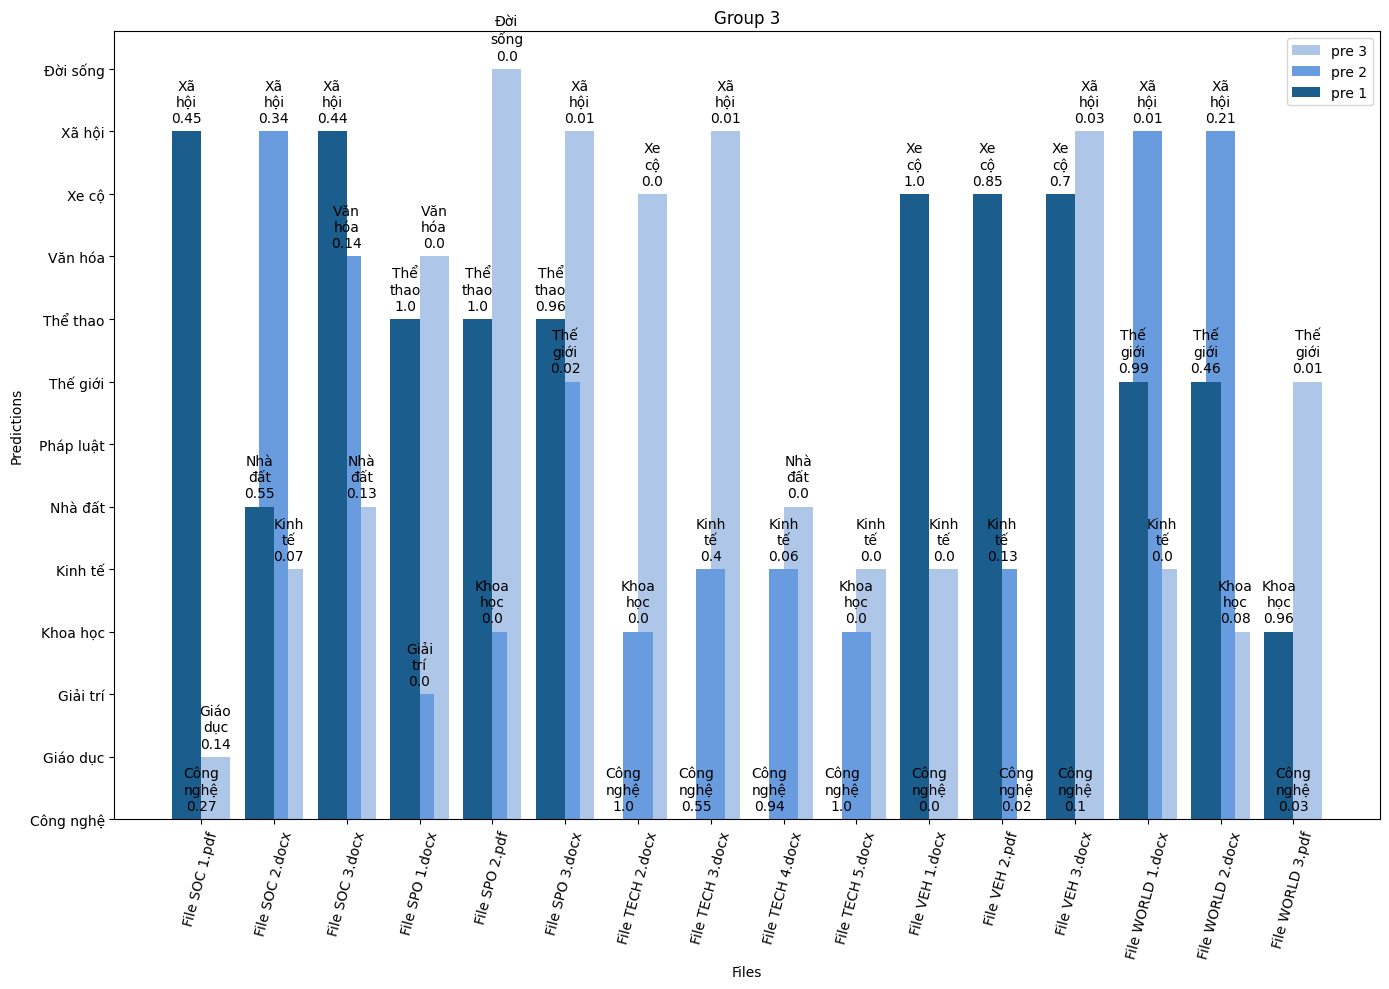

In [131]:
import os
import matplotlib.pyplot as plt

folder_path = "D:/KLTN/TEMP/text"

# Mảng để lưu các dự đoán
_predict_tag1 = []
_predict_tag2 = []
_predict_tag3 = []
_labels = []
_label = []

classes = label_encoder.classes_
for i, file_name in enumerate(os.listdir(folder_path)):
    _labels.append(f'File {file_name}')
    file_path = os.path.join(folder_path, file_name)
    
    text = read_file(file_path)    
    
    probabilities = model3_0905.predict_proba([text])[0]
    top_labels_indices = probabilities.argsort()[-3:][::-1] # ::-1 để đảo ngược mảng
    top_probabilities = probabilities[top_labels_indices]
    rounded_probabilities = [round(prob, 2) for prob in top_probabilities]

    label1 = label_encoder.inverse_transform([top_labels_indices[0]])[0].replace(" ", "\n") + "\n"+ str(rounded_probabilities[0])
    label2 = label_encoder.inverse_transform([top_labels_indices[1]])[0].replace(" ", "\n") + "\n"+ str(rounded_probabilities[1])
    label3 = label_encoder.inverse_transform([top_labels_indices[2]])[0].replace(" ", "\n") + "\n"+ str(rounded_probabilities[2])
    _label.append([label1, label2, label3])
    # Lưu dự đoán dưới dạng nhãn
    _predict_tag1.append(top_labels_indices[0])
    _predict_tag2.append(top_labels_indices[1])
    _predict_tag3.append(top_labels_indices[2])

group1_predict_tag1 = _predict_tag1[:13]
group1_predict_tag2 = _predict_tag2[:13]
group1_predict_tag3 = _predict_tag3[:13]
label1 = _label[:13]
labels1 = _labels[:13]

group2_predict_tag1 = _predict_tag1[13:26]
group2_predict_tag2 = _predict_tag2[13:26]
group2_predict_tag3 = _predict_tag3[13:26]
label2 = _label[13:26]
labels2 = _labels[13:26]

group3_predict_tag1 = _predict_tag1[26:]
group3_predict_tag2 = _predict_tag2[26:]
group3_predict_tag3 = _predict_tag3[26:]
label3 = _label[26:]
labels3 = _labels[26:]

# Tạo biểu đồ cho từng nhóm
def plot_group(labels, predict_tag1, predict_tag2, predict_tag3, title, label_def):
    x = np.arange(len(predict_tag1))
    width = 0.4
    plt.figure(figsize=(14, 10))
    colors = ['#1b5e8e', '#699cdf', '#aec7e8'] 

    bars3 = plt.bar(x + width/2, predict_tag3, width=width, align='center', label='pre 3', color=colors[2])
    bars2 = plt.bar(x, predict_tag2, width=width, align='center', label='pre 2', color=colors[1])
    bars1 = plt.bar(x - width/2, predict_tag1, width=width, align='center', label='pre 1', color=colors[0])

    for i, bars in enumerate([bars1, bars2, bars3]):
        for j, bar in enumerate(bars):
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.1, label_def[j][i], ha='center', va='bottom')

    plt.xlabel('Files')
    plt.ylabel('Predictions')
    plt.xticks(x, labels, rotation=75)
    plt.yticks(np.arange(len(classes)), classes)
    plt.title(title)
    plt.legend()
    plt.tight_layout()  
    plt.show()
    
# Vẽ biểu đồ cho từng nhóm
plot_group(labels1, group1_predict_tag1, group1_predict_tag2, group1_predict_tag3, 'Group 1', label1)
plot_group(labels2, group2_predict_tag1, group2_predict_tag2, group2_predict_tag3, 'Group 2', label2)
plot_group(labels3, group3_predict_tag1, group3_predict_tag2, group3_predict_tag3, 'Group 3', label3)

In [ ]:
import os
import matplotlib.pyplot as plt

folder_path = "D:/KLTN/TEMP/text"

# Mảng để lưu các dự đoán
predict_tag1 = []
predict_tag2 = []
predict_tag3 = []
labels = []
label = []

classes = label_encoder.classes_
for i, file_name in enumerate(os.listdir(folder_path)):
    labels.append(f'File {file_name}')
    file_path = os.path.join(folder_path, file_name)
    
    text = read_file(file_path)    
    
    probabilities = model2_0905.predict_proba([text])[0]
    top_labels_indices = probabilities.argsort()[-3:][::-1] # ::-1 để đảo ngược mảng
    top_probabilities = probabilities[top_labels_indices]
    rounded_probabilities = [round(prob, 2) for prob in top_probabilities]

    label1 = label_encoder.inverse_transform([top_labels_indices[0]])[0].replace(" ", "\n") + "\n"+ str(rounded_probabilities[0])
    label2 = label_encoder.inverse_transform([top_labels_indices[1]])[0].replace(" ", "\n") + "\n"+ str(rounded_probabilities[1])
    label3 = label_encoder.inverse_transform([top_labels_indices[2]])[0].replace(" ", "\n") + "\n"+ str(rounded_probabilities[2])
    label.append([label1, label2, label3])
    # Lưu dự đoán dưới dạng nhãn
    predict_tag1.append(top_labels_indices[0])
    predict_tag2.append(top_labels_indices[1])
    predict_tag3.append(top_labels_indices[2])

x = np.arange(len(predict_tag1))
width = 0.4
# Vẽ biểu đồ
plt.figure(figsize=(14, 10))
colors = ['#1b5e8e', '#699cdf', '#aec7e8'] 

# Vẽ biểu đồ
plt.figure(figsize=(14, 10))
bars3 = plt.bar(x + width/2, predict_tag3, width=width, align='center', label='pre 3', color=colors[2])
bars2 = plt.bar(x, predict_tag2, width=width, align='center', label='pre 2', color=colors[1])
bars1 = plt.bar(x - width/2, predict_tag1, width=width, align='center', label='pre 1', color=colors[0])


for i, bars in enumerate ([bars1, bars2, bars3]):
    for j, bar in enumerate (bars):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.1, label[j][i], ha='center', va='bottom')

plt.xlabel('Files')
plt.ylabel('Predictions')
plt.xticks(x, labels, rotation=75)
plt.yticks(np.arange(len(classes)), classes)
plt.title('Comparison of Model Predictions')
plt.legend()
plt.tight_layout()  # Điều chỉnh layout để nhãn x không bị cắt
plt.show()
